Данильченко Вадим

Классификация болезней по документу и симптомам

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from google.colab import drive
from tqdm import trange

from keras.preprocessing.text import Tokenizer
from keras import utils
import re

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
! ls drive/'My Drive'/data/diseases

Аппендицит.txt	Гепатит.txt   Колит.txt       Холицестит.txt  Энтерит.txt
Гастрит.txt	Дуоденит.txt  Панкреатит.txt  Эзофагит.txt    Язва.txt


# классифицирую сначала просто документы по сплошному тексту без разделения на предложения

In [180]:
def read_text(filename):
  f = open(filename, 'r')
  text = f.read()
  text = text.replace('\n', ' ')
  return text

path = 'drive/My Drive/data/diseases'
data = {}
for file in os.listdir(path):
  print(file)
  data[file[:-4]] = read_text(os.path.join(path, file))

data['Язва']

Аппендицит.txt
Гастрит.txt
Гепатит.txt
Дуоденит.txt
Колит.txt
Панкреатит.txt
Холицестит.txt
Эзофагит.txt
Энтерит.txt
Язва.txt


'боль, часто локализованная в эпигастрии и уменьшающаяся после еды или антацидов.  боль описывается как жгучая или грызущая, иногда как чувство голода.  Боль в эпигастральной области кислая отрыжка  изжога снижение массы тела рвота и тошнота после еды  боль после еды и в зависимости от пораженного отдела может появиться сразу или спустя 1–2 часа рвота кислым содержимым желудка  боль в животе Боль возникает в середине живота («под ложечкой»), никуда, как правило, не отдает Болевой синдром. Возникает в верхней части живота, носит непостоянный характер.  Изжога Рвота тошнота Отсутствие аппетита  жжениеи  боль в верхней части живота выше пупка тошнота рвота снижение аппетита снижение веса слабость усталость  налет на языке метеоризм чередование поноса ,запора и нормального стула неприятный запах из ротовой полости уменьшение веса тошнота рвота изжога и отрыжка кислотой  Ноющие или схваткообразные боли, слабоинтенсивные в эпигастральной области, чаще возникают натощак или непосредственно по

In [189]:
# # сформируем датафрейм

df = pd.DataFrame(data={'diseas': list(data.keys()), 'text': list(data.values())})
df.head(2)

,diseas,text
0,Аппендицит,Резкая боль в животе Повышение температуры Нап...
1,Гастрит,ГАСТРИТ СИМПТОМЫ диспепсии (тяжесть и чувство...


In [190]:
# пронумеруем категории 
df['target'] = df['diseas'].astype('category').cat.codes
# удалим примеры, для которых отсутствует метка класса
print(df.shape)
df['target'].value_counts()

(10, 3)


9    1
8    1
7    1
6    1
5    1
4    1
3    1
2    1
1    1
0    1
Name: target, dtype: int64

In [191]:
%%time
# обучим токенизатор
MAX_WORD_COUNT = 2000

tokenizer = Tokenizer(num_words=MAX_WORD_COUNT, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='UNK', char_level=False)
tokenizer.fit_on_texts(df['text'].tolist())
items = list(tokenizer.word_index.items())
print(len(items))

1999
CPU times: user 11.8 ms, sys: 938 µs, total: 12.8 ms
Wall time: 12.7 ms


In [192]:
tokenizer.word_index['37']

260

In [195]:
# преобразуем тексты в id (все слова, индексы которых будут больше MAX_WORD_COUNT, будут иметь индекс слова UNK)
X = tokenizer.texts_to_sequences(df['text'].tolist())
X[0][:20]

[99, 4, 2, 11, 25, 26, 879, 211, 5, 100, 4, 2, 11, 2, 407, 557, 3, 10, 558, 25]

In [196]:
# запишем в y индексы классов и преобразуем в one_hot вектор нулей длиной по количеству классов, имеющий 1 на пересечении индекса с нужным классом
from collections import Counter
y = df['target'].tolist()
CLASSES = len(set(y))
print('количество классов:', CLASSES)
y_cat = utils.to_categorical(y)
print('после преобразования:\n', y_cat[:2])
y_cat.shape

количество классов: 10
после преобразования:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


(10, 10)

In [197]:
# посмотрим на среднюю длину сообщений, чтобы выбрать размер среза
from keras.preprocessing.text import text_to_word_sequence
df['length'] = df['text'].apply(lambda x: len(text_to_word_sequence(x, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')))
df.groupby(['diseas'])['length'].mean()

diseas
Аппендицит     577
Гастрит        844
Гепатит        691
Дуоденит       489
Колит         1208
Панкреатит    1486
Холицестит     842
Эзофагит       794
Энтерит        829
Язва           470
Name: length, dtype: int64

In [0]:
# функция будет делать срезы некоторой длины slice_len с шагом step в последовательности sequence, которая будет ей подана на вход
def get_slices(sequence, slice_len, step):
  slices = []
  max_len = len(sequence)

  start = 0
  while (start+step<=max_len):
    slices.append(sequence[start:start+slice_len])
    start+=step
  
  return slices

In [0]:
# функция добавляет к входящей последовательности индексов текстов значения в целевую переменную
def create_dataset(sequences, target, slice_len, step):
  classes = target.shape[1]
  seq_slices = [] 
  target_to_slice = []#[[] for _ in range(target.shape[0])]
  # запишем срезы индексов длиной slice_len для каждого текста
  for i in trange(len(sequences)):
    seq_slices_tmp = get_slices(sequences[i], slice_len, step)
    seq_slices+=seq_slices_tmp
    for j in seq_slices_tmp:
      target_to_slice.append(target[i])

  seq_slices = np.asarray(seq_slices)
  target_to_slice = np.asarray(target_to_slice)

  return (seq_slices, target_to_slice)

In [200]:
slice_len = 100
step = 20

x_new, y_new = create_dataset(X, y_cat, slice_len, step)
print(x_new.shape, y_new.shape)
print(x_new[0])
print(y_new[0])

100%|██████████| 10/10 [00:00<00:00, 2077.21it/s]

(407,) (407, 10)
[99, 4, 2, 11, 25, 26, 879, 211, 5, 100, 4, 2, 11, 2, 407, 557, 3, 10, 558, 25, 26, 5, 7, 153, 4, 880, 90, 6, 37, 38, 9, 56, 121, 255, 881, 2, 408, 256, 559, 9, 91, 257, 560, 409, 42, 17, 5, 3, 6, 7, 410, 12, 411, 92, 882, 4, 2, 11, 883, 258, 142, 25, 26, 884, 6, 100, 4, 2, 37, 6, 143, 38, 9, 412, 6, 561, 318, 319, 3, 6, 320, 562, 7, 259, 563, 57, 6, 29, 4, 2, 11, 564, 2, 45, 13, 6, 565, 13, 321, 181]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=777)

In [202]:
# приведем к формату bag of words по длине словаря MAX_WORD_COUNT
x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())
x_train_bow.shape

(325, 2000)

**WITHOUT EMBEDDING**

In [204]:
# создадим граф вычислений нейросети 1
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l1

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=MAX_WORD_COUNT, name='input'))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-3))

model.fit(x_train_bow,
          y_train,
          validation_data=(x_test_bow, y_test),
          epochs=5,
          batch_size=128,
          verbose=1)

Train on 325 samples, validate on 82 samples
Epoch 1/5
325/325 [==============================] - 0s 268us/step - loss: 2.1545 - accuracy: 0.3292 - val_loss: 1.8080 - val_accuracy: 0.7317
Epoch 2/5
325/325 [==============================] - 0s 59us/step - loss: 1.5894 - accuracy: 0.8769 - val_loss: 1.3598 - val_accuracy: 0.9634
Epoch 3/5
325/325 [==============================] - 0s 47us/step - loss: 1.1083 - accuracy: 0.9785 - val_loss: 0.9390 - val_accuracy: 0.9878
Epoch 4/5
325/325 [==============================] - 0s 44us/step - loss: 0.7143 - accuracy: 0.9938 - val_loss: 0.6011 - val_accuracy: 0.9878
Epoch 5/5
325/325 [==============================] - 0s 47us/step - loss: 0.4304 - accuracy: 0.9969 - val_loss: 0.3666 - val_accuracy: 1.0000


In [0]:
def history_plot(r):
  fig, ax1 = plt.subplots()

  t = np.arange(0, len(r.history['accuracy']), 1)

  ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
  ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax2 = ax1.twinx()


  ln3 = ax2.plot(t, r.history['accuracy'], color='b', label='accuracy')
  ln4 = ax2.plot(t, r.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
  ax2.set_ylabel('accuracy')

  lns = ln1+ln2+ln3+ln4
  labs = [l.get_label() for l in lns]
  ax1.legend(lns, labs, loc=0)

  fig.tight_layout()
  plt.show()

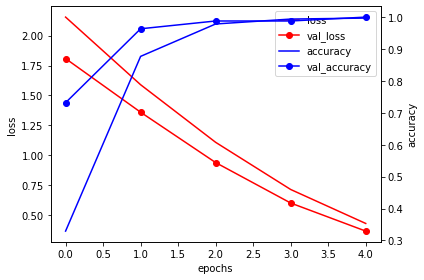

In [206]:
history_plot(model.history)

классифицировать весь документ в данном случае слегка читерство) если в бою придет какой-то один симптом из списка, есть большой шанс промазать, т.к. симптомы схожие часто встречаются между болезней.

# теперь классифицирую отдельно по симптомам в каждом документе

In [207]:
def read_text(filename):
  f = open(filename, 'r')
  text = f.read().lower()
  text = re.split(';|\n|\.', text)
  text = [i.strip() for i in text]
  text = [i for i in text if i!='']
  return list(set(text))

path = 'drive/My Drive/data/diseases'
data = {}
for file in os.listdir(path):
  print(file)
  data[file[:-4]] = read_text(os.path.join(path, file))

data['Язва']

Аппендицит.txt
Гастрит.txt
Гепатит.txt
Дуоденит.txt
Колит.txt
Панкреатит.txt
Холицестит.txt
Эзофагит.txt
Энтерит.txt
Язва.txt


['иногда рвота',
 'кровавый или темный стул',
 '«кислая» отрыжка',
 'боль описывается как жгучая или грызущая, иногда как чувство голода',
 'появление тошноты',
 'кровавая или темная дефекация',
 'изменяется цвет лица',
 'тяжесть после приема пищи',
 'неприятная отрыжка',
 'повышенная потливость',
 'неприятный запах из ротовой полости',
 'боль или дискомфорт в эпигастрии,появляющаяся 1–3 ч после еды,проходящая после приема пищи или антацидов',
 'язвенный больной интенсивно худеет',
 'тяжесть в эпигастрии',
 'отрыжка воздухом, кислым или горьким привкусом',
 'ночные и «голодные» боли',
 'отрыжка кислым',
 'запоры',
 'снижение массы тела',
 'склонность к запорам',
 'изжога и отрыжка кислотой',
 'боль возникает в середине живота («под ложечкой»), никуда, как правило, не отдает',
 'непереносимость жирной пищи',
 'усталость',
 'боль',
 'болевые ощущения при надавливании на живот',
 'рвота,возникающая внезапно,иногда во время еды',
 'белый налет на языке',
 'массы тела',
 'боль в животе',
 '

In [208]:
# сформируем датафрейм
df = pd.DataFrame(columns=['diseas', 'text'])
i=0
for k,v in data.items():
  for elem in v:
    df.loc[i, 'diseas'] = k
    df.loc[i, 'text'] = elem
    i+=1
print(df.shape)
df.head(1)

(1365, 2)


,diseas,text
0,Аппендицит,стул и газы часто задерживаются


In [209]:
# пронумеруем категории 
df['target'] = df['diseas'].astype('category').cat.codes
# удалим примеры, для которых отсутствует метка класса
print(df.shape)
df['target'].value_counts()

(1365, 3)


4    209
5    194
2    170
7    134
1    127
8    123
6    118
3    110
0     92
9     88
Name: target, dtype: int64

In [210]:
%%time
# обучим токенизатор
MAX_WORD_COUNT = 2000

tokenizer = Tokenizer(num_words=MAX_WORD_COUNT, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='UNK', char_level=False)
tokenizer.fit_on_texts(df['text'].tolist())
items = list(tokenizer.word_index.items())
print(len(items))

1999
CPU times: user 23.1 ms, sys: 766 µs, total: 23.9 ms
Wall time: 23.9 ms


In [211]:
tokenizer.word_index['37']

245

In [212]:
# преобразуем тексты в id (все слова, индексы которых будут больше MAX_WORD_COUNT, будут иметь индекс слова UNK)
X = tokenizer.texts_to_sequences(df['text'].tolist())
X[0][:20]

[39, 3, 540, 67, 872]

In [213]:
# запишем в y индексы классов и преобразуем в one_hot вектор нулей длиной по количеству классов, имеющий 1 на пересечении индекса с нужным классом
from collections import Counter
y = df['target'].tolist()
CLASSES = len(set(y))
print('количество классов:', CLASSES)
y_cat = utils.to_categorical(y)
print('после преобразования:\n', y_cat[:2])
y_cat.shape

количество классов: 10
после преобразования:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(1365, 10)

In [214]:
# посмотрим на среднюю длину сообщений, чтобы выбрать размер среза
from keras.preprocessing.text import text_to_word_sequence
df['length'] = df['text'].apply(lambda x: len(text_to_word_sequence(x, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')))
df.groupby(['diseas'])['length'].mean()

diseas
Аппендицит    5.673913
Гастрит       5.921260
Гепатит       3.611765
Дуоденит      3.745455
Колит         5.267943
Панкреатит    7.634021
Холицестит    6.932203
Эзофагит      5.283582
Энтерит       6.040650
Язва          4.772727
Name: length, dtype: float64

In [272]:
df['length'].describe()

count    1365.000000
mean        5.546520
std         4.948732
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        45.000000
Name: length, dtype: float64

In [278]:
slice_len = 30
step = 3

x_new, y_new = create_dataset(X, y_cat, slice_len, step)
print(x_new.shape, y_new.shape)
print(x_new[0])
print(y_new[0])

100%|██████████| 1365/1365 [00:00<00:00, 235450.94it/s]

(2041,) (2041, 10)
[39, 3, 540, 67, 872]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=777)

In [280]:
# приведем к формату bag of words по длине словаря MAX_WORD_COUNT
x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())
x_train_bow.shape

(1632, 2000)

**WITHOUT EMBEDDING**

In [281]:
# создадим граф вычислений нейросети 1
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l1

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=MAX_WORD_COUNT, name='input'))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-3))

model.fit(x_train_bow,
          y_train,
          validation_data=(x_test_bow, y_test),
          epochs=20,
          batch_size=128,
          verbose=1)

Train on 1632 samples, validate on 409 samples
Epoch 1/20
1632/1632 [==============================] - 0s 71us/step - loss: 2.2551 - accuracy: 0.2371 - val_loss: 2.1820 - val_accuracy: 0.4401
Epoch 2/20
1632/1632 [==============================] - 0s 34us/step - loss: 2.0898 - accuracy: 0.5257 - val_loss: 2.0268 - val_accuracy: 0.5208
Epoch 3/20
1632/1632 [==============================] - 0s 32us/step - loss: 1.8947 - accuracy: 0.5711 - val_loss: 1.8381 - val_accuracy: 0.5428
Epoch 4/20
1632/1632 [==============================] - 0s 33us/step - loss: 1.6728 - accuracy: 0.6140 - val_loss: 1.6416 - val_accuracy: 0.5697
Epoch 5/20
1632/1632 [==============================] - 0s 32us/step - loss: 1.4509 - accuracy: 0.6697 - val_loss: 1.4611 - val_accuracy: 0.6186
Epoch 6/20
1632/1632 [==============================] - 0s 32us/step - loss: 1.2524 - accuracy: 0.7298 - val_loss: 1.3079 - val_accuracy: 0.6626
Epoch 7/20
1632/1632 [==============================] - 0s 32us/step - loss: 1.0769

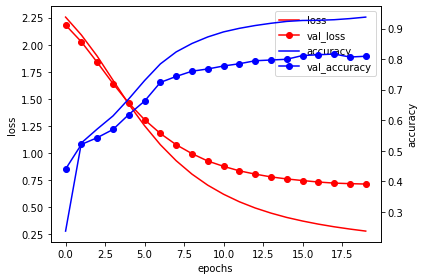

In [282]:
history_plot(model.history)

после разбиения на предложения классификация дает меньший результат, но он вполне приемлем, если брать в расчет, что в бою мдель будет применяться для определения болезни именно по одному симптому из списка, а не по всему списку (второе приемлемо, когда у нас куча записей в одном документе и не понятно к какой категории документ принадлежит)